In [1]:
import copy as cp
import numpy as np
import matplotlib as mt
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MaxNLocator
from numba import njit, prange
from sklearn.metrics import accuracy_score as acc, confusion_matrix as cfm
import sys
sys.path.append('../0_python_modules/')
import extras

In [2]:
def clusters(hc, nids=range(2,11)):
    for h in nids:
        hl = extras.get_hc_dtraj(hc, nids=h)
        print(h,_clusters(hl))
def _clusters(hl):
    return {i:np.where(hl==i)[0].shape[0] for i in np.unique(hl)}

In [3]:
def mse(pfile, pmean, chunk=1000):
    pfile = np.load(pfile, mmap_mode='r')
    pmean = np.load(pmean, mmap_mode='r')
    nobs = pfile.shape[0]
    iters = int(nobs/chunk)
    s=0
    for k in range(iters+1):
        start=i*chunk
        end=(i+1)*chunk
        s += np.sum( np.square( pmean[start:end]-pfile[start-end] ))
    return np.sqrt(s/nobs)

In [4]:
def is_outlier_free(dtrj, cfactor=2):
    labels = _clusters(dtrj)
    pops = list(labels.values())
    labels = list(labels.keys())
    cutoff = cfactor * np.sqrt(dtrj.shape[0]/len(labels))
    if np.where(pops>cutoff)[0].shape[0] == 2:
        return True
    return False

## random state difference

### mse in proximities

In [5]:
for i in range(5):
    print(mse(f'4_dtrj_random_state/saved_dtrj/prox{i}.npy', 
             '../2_jctc_urf/saved_furf/permute_pmt_mean.npy',
             chunk=100000)
         )

0.06883601942328657
0.07822117387859444
0.06993541763556
0.0715114648701958
0.08002732794325236


### labels at nids=2

In [5]:
mhc = np.load('../2_jctc_urf/saved_furf/hc_average.npy')

In [6]:
_clusters(extras.get_hc_dtraj(mhc, nids=2))

{0: 49319, 1: 104802}

In [7]:
hcs = [np.load(f'4_dtrj_random_state/saved_dtrj/hc{i}.npy') for i in range(5)]

In [8]:
for i in hcs:
    print(_clusters(extras.get_hc_dtraj(i, nids=2)))

{0: 1, 1: 154120}
{0: 104810, 1: 49311}
{0: 1, 1: 154120}
{0: 104819, 1: 49302}
{0: 48446, 1: 105675}


In [9]:
lmean = extras.get_hc_dtraj(mhc, nids=2)
rstate_f1 = []
for i in range(5):
    lhc = extras.get_relabelled_class_labels( 
        lmean, extras.get_dtraj_renumbered_outliers(
            extras.get_hc_dtraj(hcs[0], nids=3), display=False)
    )
    cmt = cfm(lmean, lhc)
    f1 = extras.get_f1_score(cmt)
    rstate_f1.append(f1)
    print(cmt, f1, '\n')

[[ 49304     15]
 [    10 104792]] 0.9997465351352997 

[[ 49304     15]
 [    10 104792]] 0.9997465351352997 

[[ 49305     14]
 [    10 104792]] 0.9997566761968489 

[[ 49305     14]
 [    10 104792]] 0.9997566761968489 

[[ 49305     14]
 [    10 104792]] 0.9997566761968489 



## fit-predict differences from efficient(all data)

In [10]:
dtrjs = [
    [
        np.load(f'2_fp3/saved_sizes/dtrj_{s}_{i}.npy')
    for i in range(5)]
for s in range(9)]

In [11]:
for i in dtrjs:
    for j in i:
        print(_clusters(j))
    print('\n')

{0: 49262, 1: 104859}
{0: 49266, 1: 104855}
{0: 49259, 1: 104862}
{0: 2, 1: 154119}
{0: 1, 1: 154120}


{0: 48616, 1: 105505}
{0: 49287, 1: 104834}
{0: 49289, 1: 104832}
{0: 104834, 1: 49287}
{0: 104829, 1: 49292}


{0: 48526, 1: 105595}
{0: 49291, 1: 104830}
{0: 49291, 1: 104830}
{0: 104826, 1: 49295}
{0: 49295, 1: 104826}


{0: 8, 1: 154113}
{0: 104819, 1: 49302}
{0: 104819, 1: 49302}
{0: 2, 1: 154119}
{0: 104827, 1: 49294}


{0: 49304, 1: 104817}
{0: 104810, 1: 49311}
{0: 104822, 1: 49299}
{0: 104820, 1: 49301}
{0: 1, 1: 154120}


{0: 104805, 1: 49316}
{0: 104815, 1: 49306}
{0: 104810, 1: 49311}
{0: 48475, 1: 105646}
{0: 1, 1: 154120}


{0: 49322, 1: 104799}
{0: 104813, 1: 49308}
{0: 104807, 1: 49314}
{0: 49298, 1: 104823}
{0: 104807, 1: 49314}


{0: 49321, 1: 104800}
{0: 104811, 1: 49310}
{0: 49316, 1: 104805}
{0: 48435, 1: 105686}
{0: 104809, 1: 49312}


{0: 48361, 1: 105760}
{0: 104810, 1: 49311}
{0: 49314, 1: 104807}
{0: 104809, 1: 49312}
{0: 104796, 1: 49325}




### qualitatively, the results are same as efficient 

In [23]:
fp_f1 = []
for dtrj in dtrjs:
    ff = []
    for lhc in dtrj:
        if is_outlier_free(lhc):
            lhc = extras.get_relabelled_class_labels(lmean, lhc)
            cmt = cfm(lmean, lhc)
            f1 = extras.get_f1_score(cmt)
            ff.append(f1)
            print(cmt, f1, '\n')
    fp_f1.append(ff)
    print('\n')

[[ 49254     65]
 [     8 104794]] 0.9992594921942363 

[[ 49258     61]
 [     8 104794]] 0.9993000963635441 

[[ 49251     68]
 [     8 104794]] 0.9992290369047859 



[[ 48614    705]
 [     2 104800]] 0.9927809261244702 

[[ 49278     41]
 [     9 104793]] 0.9994929314646167 

[[ 49276     43]
 [    13 104789]] 0.9994320947590459 

[[ 49276     43]
 [    11 104791]] 0.9994523659817861 

[[ 49280     39]
 [    12 104790]] 0.9994828163186662 



[[ 48521    798]
 [     5 104797]] 0.9917931422147274 

[[ 49284     35]
 [     7 104795]] 0.9995740797079403 

[[ 49282     37]
 [     9 104793]] 0.9995335158706014 

[[ 49285     34]
 [    10 104792]] 0.9995538158882107 

[[ 49282     37]
 [    13 104789]] 0.9994929726002393 



[[ 49297     22]
 [     5 104797]] 0.9997262246377546 

[[ 49293     26]
 [     9 104793]] 0.9996451060119041 

[[ 49283     36]
 [    11 104791]] 0.9995233894111324 



[[ 49294     25]
 [    10 104792]] 0.9996451132088864 

[[ 49297     22]
 [    14 104788]] 0.999

In [24]:
sizes = np.arange(0.1,1,0.1)

In [25]:
means = []
stds = []
for i in fp_f1:
    means.append(np.mean(i))
    stds.append(np.std(i))

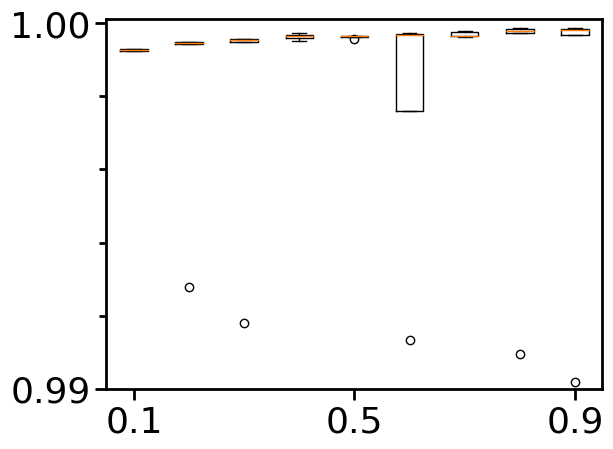

In [54]:
fig,ax=plt.subplots()
ax.boxplot(fp_f1)
ax.set_ylim(0.99,1.0001)
ax.set_yticks([0.99,1])
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
# ax.set_xticks(ticks=np.arange(1,10), labels=np.round(np.arange(0.1,1,0.1),2))
ax.set_xticks(ticks=[1,5,9],labels=['0.1','0.5','0.9'])
ax.tick_params(labelsize=26, length=8, width=2)
ax.tick_params(which='minor', length=5, width=2)
ax.spines[:].set_linewidth(2)
plt.show()

In [4]:
np.std([65,61,68])

2.8674417556808756

In [6]:
np.std([49254, 49258, 49251])

2.8674417556808756